Transfer Learning for Computer Vision Tutorial

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#transfer-learning-for-computer-vision-tutorial

## Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()


## Load Data    

In [5]:
#Downlaod
import os
import requests
import tarfile


url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
download_path = "hymenoptera_dataset.tgz"


response = requests.get(url)
if response.status_code == 200:
    with open(download_path, 'wb') as f:
        f.write(response.content)
else:
    print("Failed to download the dataset.")

In [6]:
with tarfile.open(download_path, 'r:gz') as tar:
    tar.extractall()

os.remove(download_path)

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize

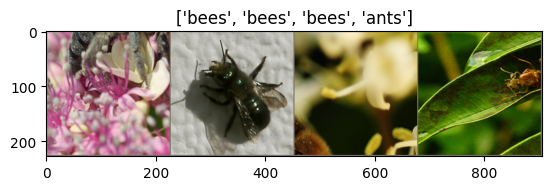

In [11]:
def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Explore

## Train

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Eval Predictions

## Finetuning

In [14]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\kaddo/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [15]:
# Train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6919 Acc: 0.6639
val Loss: 0.5115 Acc: 0.7974

Epoch 1/24
----------
train Loss: 0.3591 Acc: 0.8361
val Loss: 0.2076 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.6163 Acc: 0.7910
val Loss: 0.4581 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.6292 Acc: 0.7500
val Loss: 0.4335 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.4598 Acc: 0.7951
val Loss: 0.6410 Acc: 0.7974

Epoch 5/24
----------
train Loss: 0.5323 Acc: 0.8074
val Loss: 0.5384 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.4519 Acc: 0.8074
val Loss: 0.1958 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.3592 Acc: 0.8484
val Loss: 0.1898 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3975 Acc: 0.8238
val Loss: 0.1963 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2881 Acc: 0.8811
val Loss: 0.1900 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3261 Acc: 0.8648
val Loss: 0.1834 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3569 Acc: 0.8566
val Loss: 0.1848 Acc: 0.9281

Ep

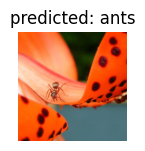

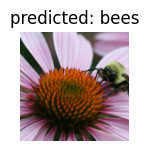

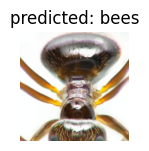

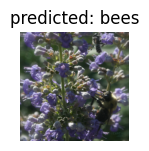

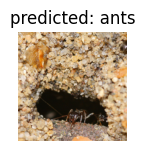

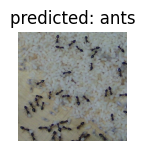

In [17]:
visualize_model(model_ft)

## Train and Evaluate

In [18]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5739 Acc: 0.6762
val Loss: 0.2223 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5714 Acc: 0.7500
val Loss: 0.2660 Acc: 0.8954

Epoch 2/24
----------
train Loss: 0.6956 Acc: 0.7049
val Loss: 0.2146 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.5629 Acc: 0.7582
val Loss: 0.2097 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.5067 Acc: 0.7910
val Loss: 0.1659 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3835 Acc: 0.8443
val Loss: 0.1998 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.5458 Acc: 0.7623
val Loss: 0.1889 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.4406 Acc: 0.8074
val Loss: 0.2058 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3768 Acc: 0.8361
val Loss: 0.2048 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.4102 Acc: 0.8074
val Loss: 0.2575 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3124 Acc: 0.8525
val Loss: 0.2178 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3083 Acc: 0.8566
val Loss: 0.2160 Acc: 0.9412

Ep

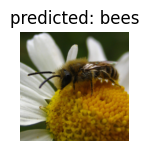

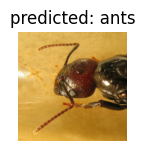

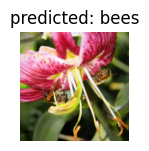

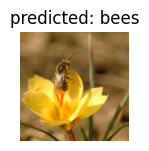

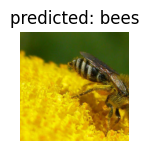

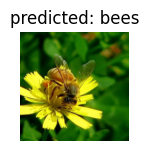

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()